In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import logging

import ipyvolume as ipv
import ipywidgets as widgets

from ipywidgets import FloatProgress
from IPython.display import display, Image

from tyssue import HistoryHdf5
from tyssue.solvers import QSSolver


from tyssue.draw import sheet_view, browse_history
from tyssue.io import hdf5
from tyssue.draw import highlight_faces, create_gif, highlight_cells


from pathlib import Path

from utils import (
    WAMonolayerGeometry as geom,
    MonolayerView,
    get_initial_follicle,
    get_solver,
    get_polar_cells,
    update_gradient
)

class LogWidget(widgets.HTML):
    
    def write(self, record):
        self.value = record
    def flush(self):
        self.value = ""

logger = logging.getLogger("tyssue")
logger.setLevel("DEBUG")
handled = False
if not handled:
    hand = logging.FileHandler("follicle.log")
    hand.setLevel("INFO")
    logger.addHandler(hand)
    handled = True
        
        
logging_widget = LogWidget()
handler = logging.StreamHandler(logging_widget)
handler.setLevel("INFO")
logger.addHandler(handler)

## Follicle monolayer creation


## Base mechanical model


By analogy with 2D Manning model (by a suggestion she did during a communication, I assume this will be published some time) we can write the basic potiential with

$$
E = \frac{K_\ell}{2}(V_\ell - V_\ell^0)^2 + \sum_c \frac{K_v}{2}(V_c - V_c^0)^2 + \frac{K_A}{2}(A_c - A_c^0)^2
$$

By setting $V_c^0 = 1$ and $K_c^0 = 1$, we rewrite this:

$$
E = \frac{K_\ell}{2}(V_\ell - V_\ell^0)^2 + \sum_c \frac{1}{2}(V_c - 1)^2 + \frac{K_A}{2}(A_c - s^0)^2
$$

Here $s^0$ is the form factor (as in 2D)

For a sphere, the ratio $A / V^{2/3}$ is equal to $(36\pi)^{1/3} \approx 4.84$

For a [truncated octahedron](https://en.wikipedia.org/wiki/Truncated_octahedron) (regular cells in bulk), it's 5.31 and 8.14 for a honeycomb (cuboidal cells).

## Cell area as a weighted sum of face areas


For now the model is isotropic, so cells will tend to adopt the most spherical shape possible. In order to have polarisation, we can introduce a factor (or weight) on each face of the cell to modulate its effective contribution to the total area, the total area $A_c$ is replaced by the weighted area $A'_c$:

$$
A_c = \sum_f A_f \quad \mbox{becomes}\\
A'_c = \frac{n_f}{\sum_f w_f}\sum_f w_fA_f
$$

If all the weights are equal, the weighted area is equal to the normal area.



### Settings for the mechanical model

In [2]:
# Number of cells
Nc = 200

specs = {
    "cell": {
        "is_alive": 1,
        "vol_elasticity": 1.0,
        "prefered_vol": 1.0,
        "weighted_area": 1.0,
        "area_elasticity": 0.1,
        "prefered_area": 4.6,  # form factor
    },
    "face": {
        "weight": 1.0,
        "is_alive": 1,
    },
    "settings": {
        "lumen_vol_elasticity": 1.0e-3,
        "lumen_prefered_vol": 300,
        "apical_weight": 1.0,
    },
}


In [3]:
follicle, model = get_initial_follicle(specs)
print(f"Follicle has {follicle.Nc} cells")
print(follicle.settings)

Finding static equilibrium
Follicle has 216 cells
{'lumen_side': 'apical', 'lumen_vol': 280.90998584239736, 'lumen_vol_elasticity': 0.001, 'lumen_prefered_vol': 300, 'apical_weight': 1.0}


#### 3D vizualisation

In [4]:
draw_specs = {
    'edge': {
        'visible': False,
    },
    'face': {
        'visible': True,
        'color': lambda sheet: sheet.face_df['area']
    },
}

ipv.clear()

# filter visible cells

follicle.face_df['visible'] = (
    (follicle.face_df['y'] > 0)
    | (follicle.face_df['x'] > 0)
)

fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

## Contractility gradient

The contractility gradient is modeled as an increase in the cells apical face _weight_

In [5]:
parameters = {
    "amp": 6,
    "span": 3,
 }

In [6]:
polar_cells = get_polar_cells(follicle)

update_gradient(follicle, polar_cells, parameters['amp'], parameters["span"])

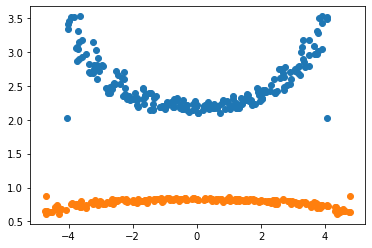

In [7]:

fig, ax = plt.subplots()
ax.plot(follicle.face_df.loc[follicle.apical_faces, "z"],
        follicle.face_df.loc[follicle.apical_faces, "weight"], 'o')
ax.plot(follicle.face_df.loc[follicle.basal_faces, "z"],
        follicle.face_df.loc[follicle.basal_faces, "weight"], 'o')

In [8]:

ipv.clear()
follicle.face_df['visible'] = True
follicle.face_df.loc[follicle.basal_faces, 'visible'] = False

fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

### Initial quasistatic equilibrium with the chosen gradient parameters

In [9]:
quasistatic_solve = True

if quasistatic_solve:
    solver = QSSolver()
    res = solver.find_energy_min(follicle, geom, model)
    print(res.message)


b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [10]:
follicle.face_df['visible'] = (
    (follicle.face_df['y'] > 0)
    | (follicle.face_df['x'] > 0)
)
ipv.clear()
fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

### More detailed viewer

In [11]:


MonolayerView(follicle, **draw_specs)

MonolayerView(children=(Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(…

## Cell division and dynamic model

$$
\ln(V_\mathrm{lum})(t) = a + k_V t\\
V_\mathrm{lum}(t) = V_0 e^{k_V t}
$$



In [12]:
follicle.update_specs(
    {'settings':
     {
        # Critical length to trigger rearangements
        "threshold_length": 1e-1,  
        # Frequency of rearangements
        "p_4": 1.,
        "p_5+": 0.1,
    },
    'vert': {
        "viscosity": 0.1
    },
})
follicle.cell_df["id"] = follicle.cell_df.index
polar_cells_ids = tuple(follicle.cell_df.loc[list(polar_cells), "id"])

parameters = {
    "amp": 6,
    "span": 3,
    "growth_rate": 0.02,
    "growth_noise": 0.02,
    "critical_vol": 2.0,
    "autonomous": True,
    "polar_cells_ids": polar_cells_ids,
    "lumen_growth_rate": 0.014
}
    
base_dir = Path("../data")
time_stamp = datetime.today().strftime("%y-%m-%d-%H-%M-%S")
history_file = Path(f"hist2D_{time_stamp}.hf5")

# We take the time unit as 1/100th of a development stage
dt = 5e-2

solver = get_solver(follicle, model, dt, base_dir, history_file, parameters)
    
    

The created solver resolves the system of first order differential equations:

$$\eta v = \sum F $$

Where the forces are computed as the opposite of the gradients from the model


In [ ]:
solver.solve(60, dt)

In [47]:
draw_specs["edge"]["visible"] = True

browse_history(solver.history, **draw_specs)


interactive(children=(IntSlider(value=0, description='i', max=1278), Output()), _dom_classes=('widget-interact…

In [48]:
eptm = solver.eptm